# Previsione della fascia di prezzo dei cellulari in base alle caratteristiche

Progetto di Programmazione di Applicazioni Data Intensive 
a.a. 2023/24

**Realizzato da:**
Francesco Marcaccini

francesco.marcaccini@studio.unibo.it


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\User\anaconda3\envs\va\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Descrizione del Problema

Il dataset preso in esame contiene i dati relativi a 45000 clienti di una banca, di cui sono note alcune informazioni riguardanti i dati passati e anagrafici.
Date queste informazioni vogliamo prevedere se un determinato utente si iscrivera' ad un deposito.

Questi dati sono presi da [Kaggle](https://www.kaggle.com/datasets/thedevastator/bank-term-deposit-predictions)

### Significato delle colonne

In [3]:
import os.path
path = "./Dataset/banking_train.csv"
if not os.path.exists(path):
    print("Dataset mancante")

dataset = pd.read_csv(path, index_col=0)

In [4]:
dataset["id"] = range(1, len(dataset) + 1)
dataset.insert(0, "age", dataset.index)
dataset.set_index("id", inplace=True)
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Una descrizione piu' esaustiva delle variabili:

- `age`: L'eta' del cliente
- `job`: Il tipo di lavoro del cliente
- `marital`: Lo stato coniugale del cliente
- `education`: Il livello educativo raggiunto dal cliente
- `default`: Se il cliente ha credito di default o no
- `balance`: I soldi all'interno dell'account del cliente
- `housing`: Se il cliente ha un prestito sulla casa o no
- `loan`: Se il cliente ha un prestito o no
- `contact`: Tipo di mezzo di comunicazione usato per contattare il cliente
- `day`: Giorno del mese in cui il cliente e' stato contattato l'ultima volta
- `month`: Mese in cui il cliente e' stato contattato l'ultima volta
- `duration`: Durata in secondi dell'ultimo contatto con il cliente durante la campagna precedente
- `campaign`: Il numero di volte che il determinato utente e' stato contattato in questa campagna
- `pdays`: Il numero di giorni passati dopo l'ultimo contatto dalla precedente campagna
- `previews`: Il numero di volte che il determinato utente e' stato contattato nella campagna precedente
- `poutcome`: Risultato della campagna precedente

La variabile che tenteremo di predirre:
- `y`: Iscrizione o no dell'utente al deposito

In [7]:
dataset.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## Preparazione dei dati

Iniziamo con il controllare il numero di valori nulli presenti per ogni colonna.

In [8]:
dataset.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Possiamo notare che il nostro dataset non presenta valori nulli, e pertanto non è necessario effettuare alcuna modifica.

In [9]:
def plot_bar(x, y, title, xlabel, ylabel, subplot=(1, 1, 1)):
    plt.subplot(*subplot)
    sns.barplot(x=x, y=y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [10]:
def plot_linear(data,  title, xlabel, ylabel, figsize=(15, 5), subplot=(1, 1, 1)):
    plt.figure(figsize=figsize)
    sns.kdeplot(data=data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [11]:
def plot_hist(data, title, xlabel, ylabel, bins=20, subplot=(1, 1, 1), color="blue"):
    plt.subplot(*subplot)
    plt.hist(data, bins=bins, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [12]:
def plot_box(data, title, ylabel, subplot=(1, 1, 1)):
    plt.subplot(*subplot)
    plt.boxplot(data)
    plt.title(title)
    plt.ylabel(ylabel)

In seguito analizziamo i dati, per vedere se alcuni di questi sono sbilanciati.

In [13]:
dataset["default"].value_counts()

no     44396
yes      815
Name: default, dtype: int64

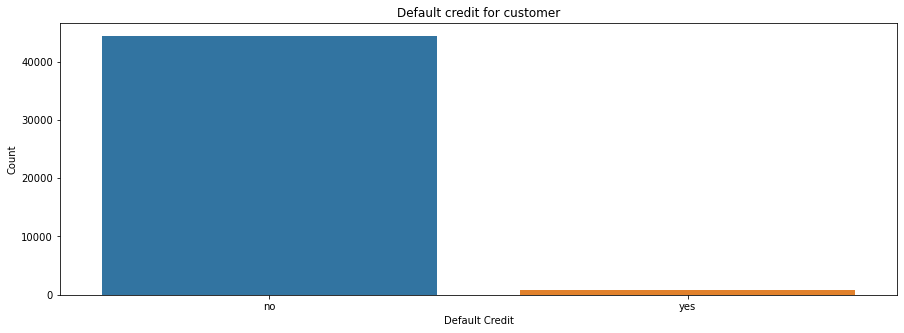

In [14]:
default_counts = dataset["default"].value_counts()
plt.figure(figsize=(15, 5))
plot_bar(default_counts.index, default_counts.values, "Default credit for customer", "Default Credit", "Count")
plt.show()

Come si puo' vedere la distribuzione dei valori e' completamente sbilanciata verso il no, rendendo questa variabile pressoche' inutilizzabile.
Percio' verra' droppata dal dataset.

In [15]:
dataset.drop(columns=["default"], inplace=True)

In [16]:
dataset["contact"].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

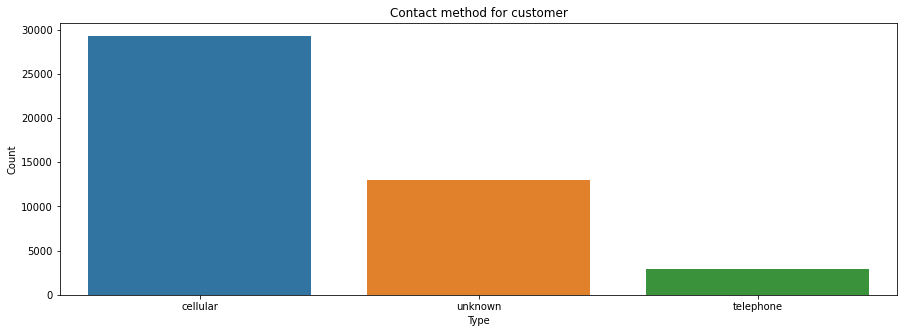

In [17]:
contact_counts = dataset["contact"].value_counts()
plt.figure(figsize=(15, 5))
plot_bar(contact_counts.index, contact_counts.values, "Contact method for customer", "Type", "Count")
plt.show()

In questo caso gli unknown sono molto alti, e il restante dei dati e' solamente cellulare. Una scelta sarebbe impostare gli unknown ad other e lasciarli nel dataset, ma penso sia piu' opportuno rimuovere questa variabile dal dataset, poiche' lasciarla potrebbe portare a risultati non corretti. 

In [18]:
dataset.drop(columns=["contact"], inplace=True)

In [19]:
dataset["previous"].value_counts()

0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
20         8
23         8
18         6
22         6
24         5
27         5
21         4
29         4
25         4
30         3
38         2
37         2
26         2
28         2
51         1
275        1
58         1
32         1
40         1
55         1
35         1
41         1
Name: previous, dtype: int64

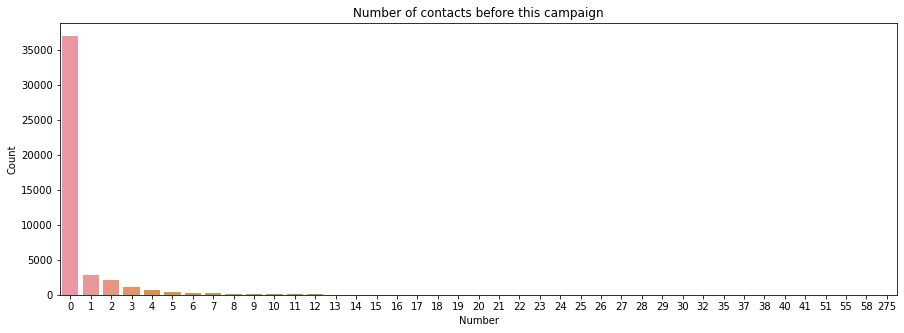

In [20]:
previous_counts = dataset["previous"].value_counts()
plt.figure(figsize=(15, 5))
plot_bar(previous_counts.index, previous_counts.values, "Number of contacts before this campaign", "Number", "Count")
plt.show()

Possiamo notare che la maggiorparte degli utenti e' stata contattata 0 volte precedentemente, portando questo dato ad essere inutilizzabile. Portandomi quindi a dropparlo.

In [21]:
dataset.drop(columns=["previous"], inplace=True)

In [22]:
dataset["poutcome"].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

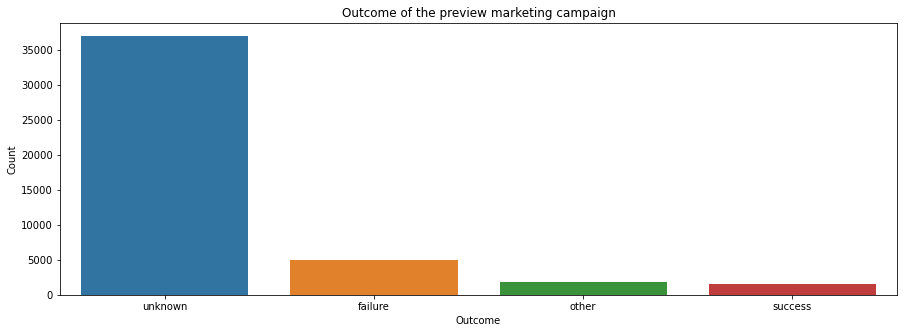

In [23]:
poutcome_counts = dataset["poutcome"].value_counts()
plt.figure(figsize=(15, 5))
plot_bar(poutcome_counts.index, poutcome_counts.values, "Outcome of the preview marketing campaign", "Outcome", "Count")
plt.show()

Considerando che quasi il 90% dei valori sono sconosciuti, si decide di eliminare la colonna.

In [24]:
dataset.drop(columns=["poutcome"], inplace=True)

In [25]:
dataset.head()

,age,job,marital,education,balance,housing,loan,day,month,duration,campaign,pdays,y
id,,,,,,,,,,,,,
1,58,management,married,tertiary,2143,yes,no,5,may,261,1,-1,no
2,44,technician,single,secondary,29,yes,no,5,may,151,1,-1,no
3,33,entrepreneur,married,secondary,2,yes,yes,5,may,76,1,-1,no
4,47,blue-collar,married,unknown,1506,yes,no,5,may,92,1,-1,no
5,33,unknown,single,unknown,1,no,no,5,may,198,1,-1,no


In seguito osserviamo i dati di tipo category, e correggiamo quelli con unkown. Se il valore uknown non e' molto elevato da creare problemi possiamo rimuovere i record dal dataset.

In [26]:
dataset["job"].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

Si noti che il valore di "unknown" non e' molto elevato, quindi si decidere di rimuovere i record che lo contengono.

In [27]:
dataset.drop(dataset[dataset["job"] == "unknown"].index, inplace=True)

In [28]:
dataset["education"].value_counts()

secondary    23131
tertiary     13262
primary       6800
unknown       1730
Name: education, dtype: int64

In [29]:
dataset.drop(dataset[dataset["education"] == "unknown"].index, inplace=True)

In fine togliamo i valori anomali dove presenti

In [30]:
dataset["balance"].describe()

count     43193.000000
mean       1354.027342
std        3042.103625
min       -8019.000000
25%          71.000000
50%         442.000000
75%        1412.000000
max      102127.000000
Name: balance, dtype: float64

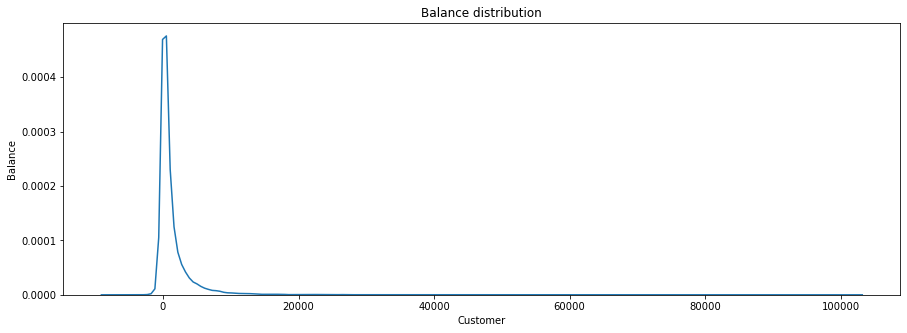

In [31]:
plot_linear(dataset["balance"], "Balance distribution", "Customer", "Balance")

Come possiamo vedere dalle informazioni riportate sopra, la colonna balance ha un valore minimo di -8019 e un valore massimo di 102127, che sono molto distanti sia dalla media che dal 25 e 75 percentile. Per questo togliamo i casi estremi, ossia rimuoviamo il 2.5% inferiore e superiore.

In [32]:
dataset.drop(dataset[(dataset['balance'] > dataset['balance'].quantile(0.975)) | (dataset['balance'] < dataset['balance'].quantile(0.025))].index, inplace=True)

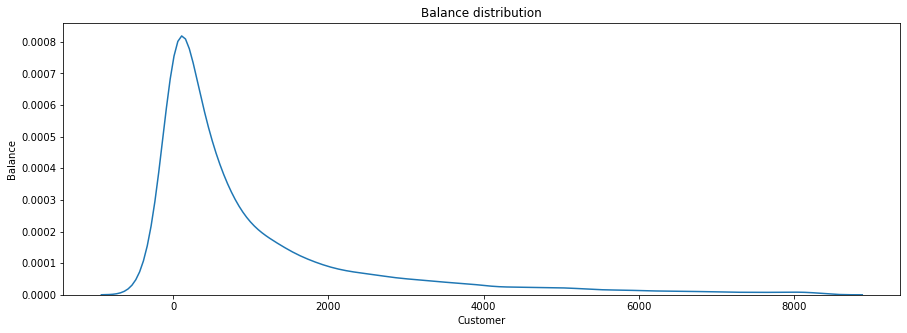

In [33]:
plot_linear(dataset["balance"], "Balance distribution", "Customer", "Balance")

In [34]:
dataset.head()

,age,job,marital,education,balance,housing,loan,day,month,duration,campaign,pdays,y
id,,,,,,,,,,,,,
1,58,management,married,tertiary,2143,yes,no,5,may,261,1,-1,no
2,44,technician,single,secondary,29,yes,no,5,may,151,1,-1,no
3,33,entrepreneur,married,secondary,2,yes,yes,5,may,76,1,-1,no
6,35,management,married,tertiary,231,yes,no,5,may,139,1,-1,no
7,28,management,single,tertiary,447,yes,yes,5,may,217,1,-1,no


In [35]:
dataset.describe()

,age,balance,day,duration,campaign,pdays
count,41036.000000,41036.000000,41036.000000,41036.000000,41036.000000,41036.000000
mean,40.702042,1048.195487,15.770153,258.103616,2.756385,40.688006
std,10.510637,1527.452289,8.309306,258.857520,3.064799,100.818176
min,18.000000,-378.000000,1.000000,0.000000,1.000000,-1.000000
25%,32.000000,84.000000,8.000000,103.000000,1.000000,-1.000000
50%,39.000000,442.000000,16.000000,180.000000,2.000000,-1.000000
75%,48.000000,1335.000000,21.000000,318.000000,3.000000,-1.000000
max,95.000000,8334.000000,31.000000,4918.000000,58.000000,871.000000


## Esplorazione dei dati

Visualizziamo le distribuzioni di tutte le variabili continue del dataset.

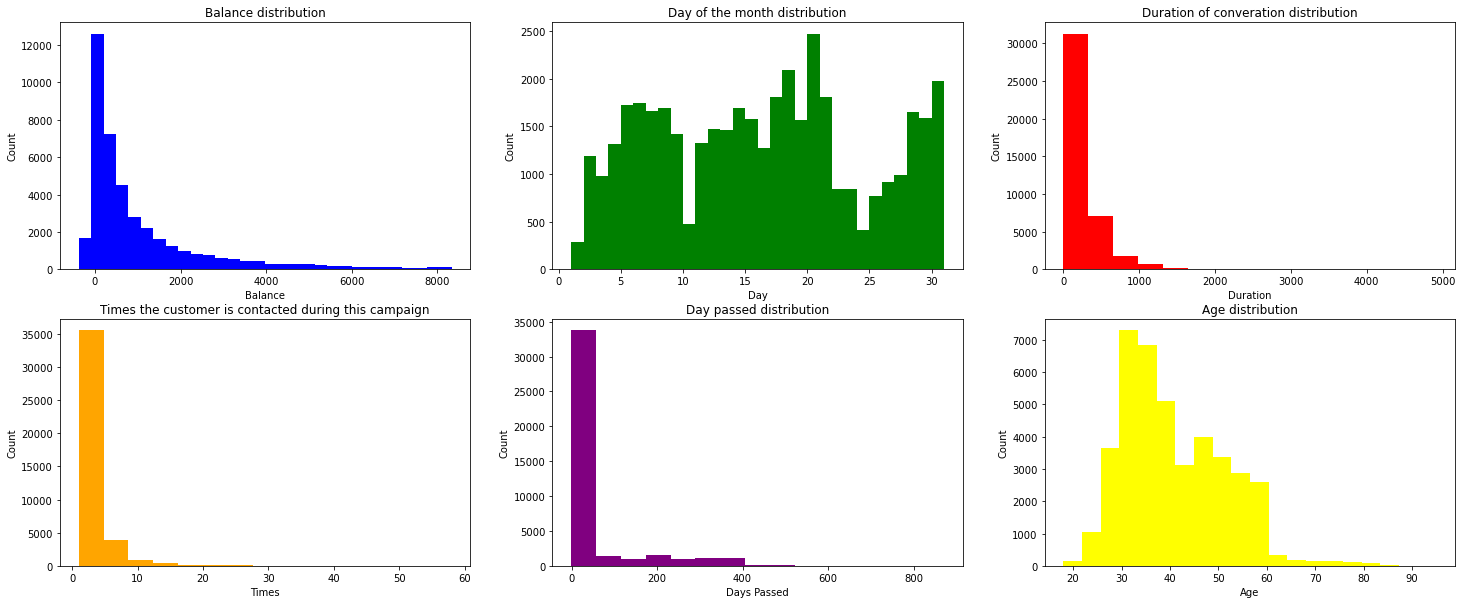

In [36]:
plt.figure(figsize=(25, 10))
plot_hist(dataset["balance"], "Balance distribution", "Balance", "Count", bins=30, subplot=(2, 3, 1))
plot_hist(dataset["day"], "Day of the month distribution", "Day", "Count", bins=30, subplot=(2, 3, 2), color="green")
plot_hist(dataset["duration"], "Duration of converation distribution", "Duration", "Count", bins=15, subplot=(2, 3, 3), color="red")
plot_hist(dataset["campaign"], "Times the customer is contacted during this campaign", "Times", "Count", bins=15, subplot=(2, 3, 4), color="orange")
plot_hist(dataset["pdays"], "Day passed distribution", "Days Passed", "Count", bins=15, subplot=(2, 3, 5), color="purple")
plot_hist(dataset["age"], "Age distribution", "Age", "Count", bins=20, subplot=(2, 3, 6), color="yellow")
plt.show()

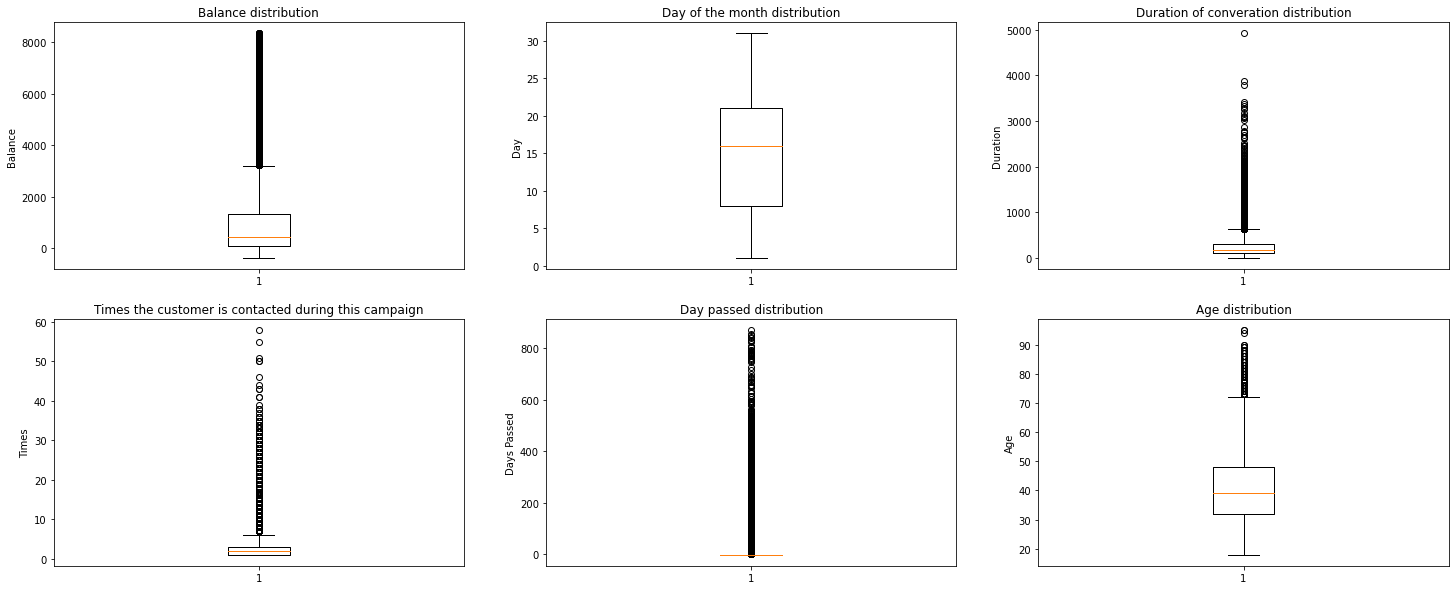

In [37]:
plt.figure(figsize=(25, 10))
plot_box(dataset["balance"], "Balance distribution", "Balance", subplot=(2, 3, 1))
plot_box(dataset["day"], "Day of the month distribution", "Day", subplot=(2, 3, 2))
plot_box(dataset["duration"], "Duration of converation distribution", "Duration", subplot=(2, 3, 3))
plot_box(dataset["campaign"], "Times the customer is contacted during this campaign", "Times", subplot=(2, 3, 4))
plot_box(dataset["pdays"], "Day passed distribution", "Days Passed", subplot=(2, 3, 5))
plot_box(dataset["age"], "Age distribution", "Age", subplot=(2, 3, 6))
plt.show()

Ora visualizziamo tutte le variabile di tipo categorico

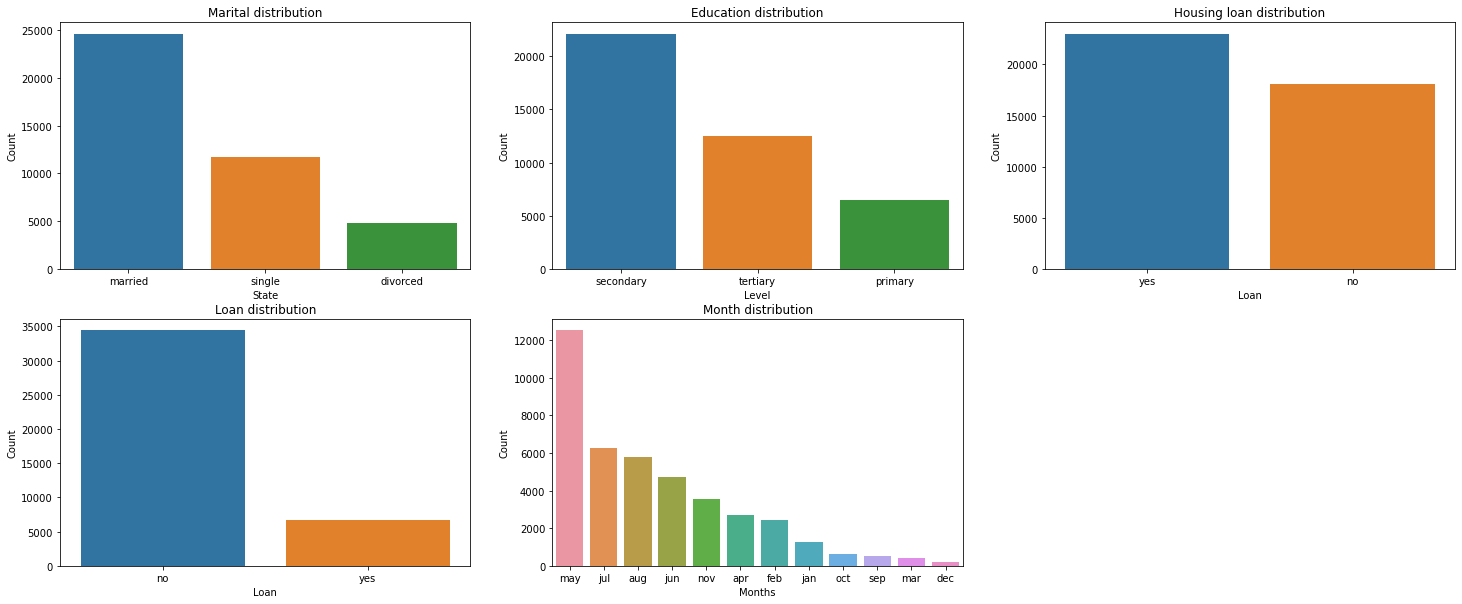

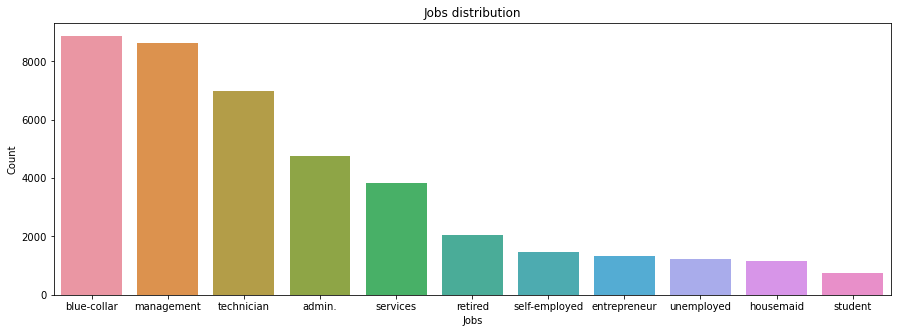

In [38]:
plt.figure(figsize=(25, 10))
plot_bar(dataset["marital"].value_counts().index, dataset["marital"].value_counts().values, "Marital distribution", "State", "Count", subplot=(2, 3, 1))
plot_bar(dataset["education"].value_counts().index, dataset["education"].value_counts().values, "Education distribution", "Level", "Count", subplot=(2, 3, 2))
plot_bar(dataset["housing"].value_counts().index, dataset["housing"].value_counts().values, "Housing loan distribution", "Loan", "Count", subplot=(2, 3, 3))
plot_bar(dataset["loan"].value_counts().index, dataset["loan"].value_counts().values, "Loan distribution", "Loan", "Count", subplot=(2, 3, 4))
plot_bar(dataset["month"].value_counts().index, dataset["month"].value_counts().values, "Month distribution", "Months", "Count", subplot=(2, 3, 5))
plt.show()
plt.figure(figsize=(15, 5))
plot_bar(dataset["job"].value_counts().index, dataset["job"].value_counts().values, "Jobs distribution", "Jobs", "Count")
plt.show()

Ora visualizziamo la variabile `y`, che e' la nostra variabile target.

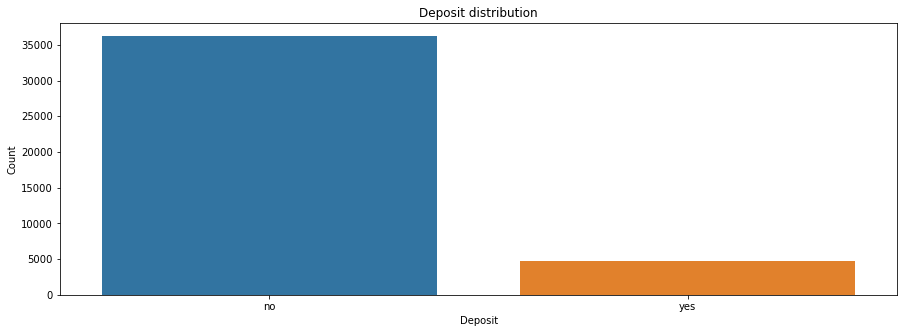

In [39]:
plt.figure(figsize=(15, 5))
plot_bar(dataset["y"].value_counts().index, dataset["y"].value_counts().values, "Deposit distribution", "Deposit", "Count")
plt.show()

Come possiamo vedere dal grafico la distribuzione della variabile target e' molto sbilanciata portando a risultati non ottimali. Per risolvere questo problema possiamo utilizzare la tecnica di oversampling, in particolare la tecnica SMOTE (Synthetic Minority Oversampling Technique) che consiste nel creare nuovi dati sintetici per la classe minoritaria.

Ora dobbiamo trasformare i valori categorici in rispettivi valori numerici, e in seguito potremo creare una matrice di correlazione per analizzare quali variabili sono piu' dipendenti le une dalle altre.

Per far questo trasformiamo le variabili che possono assumere N valori > 2 in N variabili separate che possono assumere valore 0 o 1, di queste N variabili N - 1 saranno poste a 0 mentre quella corretta sara' posta a 1.
Nel caso in cui le variabili categoriche possano assumere 2 valori facciamo una mappatura della variabile dal valore positivo a 1 e di quello negativo a 0.

In [40]:
categorical_columns = ["job", "marital", "education", "month"]
for categorical_column in categorical_columns:
    dummies = dataset[categorical_column].str.get_dummies()
    dataset = dataset.merge(dummies, left_index=True, right_index=True)
    dataset.drop(columns=[categorical_column], inplace=True)
dataset.head()

,age,balance,housing,loan,day,duration,campaign,pdays,y,admin.,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
id,,,,,,,,,,,,,,,,,,,,,
1,58,2143,yes,no,5,261,1,-1,no,0,...,0,0,0,0,0,0,1,0,0,0
2,44,29,yes,no,5,151,1,-1,no,0,...,0,0,0,0,0,0,1,0,0,0
3,33,2,yes,yes,5,76,1,-1,no,0,...,0,0,0,0,0,0,1,0,0,0
6,35,231,yes,no,5,139,1,-1,no,0,...,0,0,0,0,0,0,1,0,0,0
7,28,447,yes,yes,5,217,1,-1,no,0,...,0,0,0,0,0,0,1,0,0,0


In [41]:
dataset["housing"] = dataset["housing"].replace({"yes": 1, "no": 0})
dataset["loan"] = dataset["loan"].replace({"yes": 1, "no": 0})
dataset["y"] = dataset["y"].replace({"yes": 1, "no": 0})

In [42]:
dataset.head()

,age,balance,housing,loan,day,duration,campaign,pdays,y,admin.,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
id,,,,,,,,,,,,,,,,,,,,,
1,58,2143,1,0,5,261,1,-1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,44,29,1,0,5,151,1,-1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,33,2,1,1,5,76,1,-1,0,0,...,0,0,0,0,0,0,1,0,0,0
6,35,231,1,0,5,139,1,-1,0,0,...,0,0,0,0,0,0,1,0,0,0
7,28,447,1,1,5,217,1,-1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [43]:
def plot_correlation(data, figsize=(30, 20)):
    plt.figure(figsize=figsize)
    sns.heatmap(data, cmap="coolwarm", annot=True, fmt="0.2f")
    plt.show()

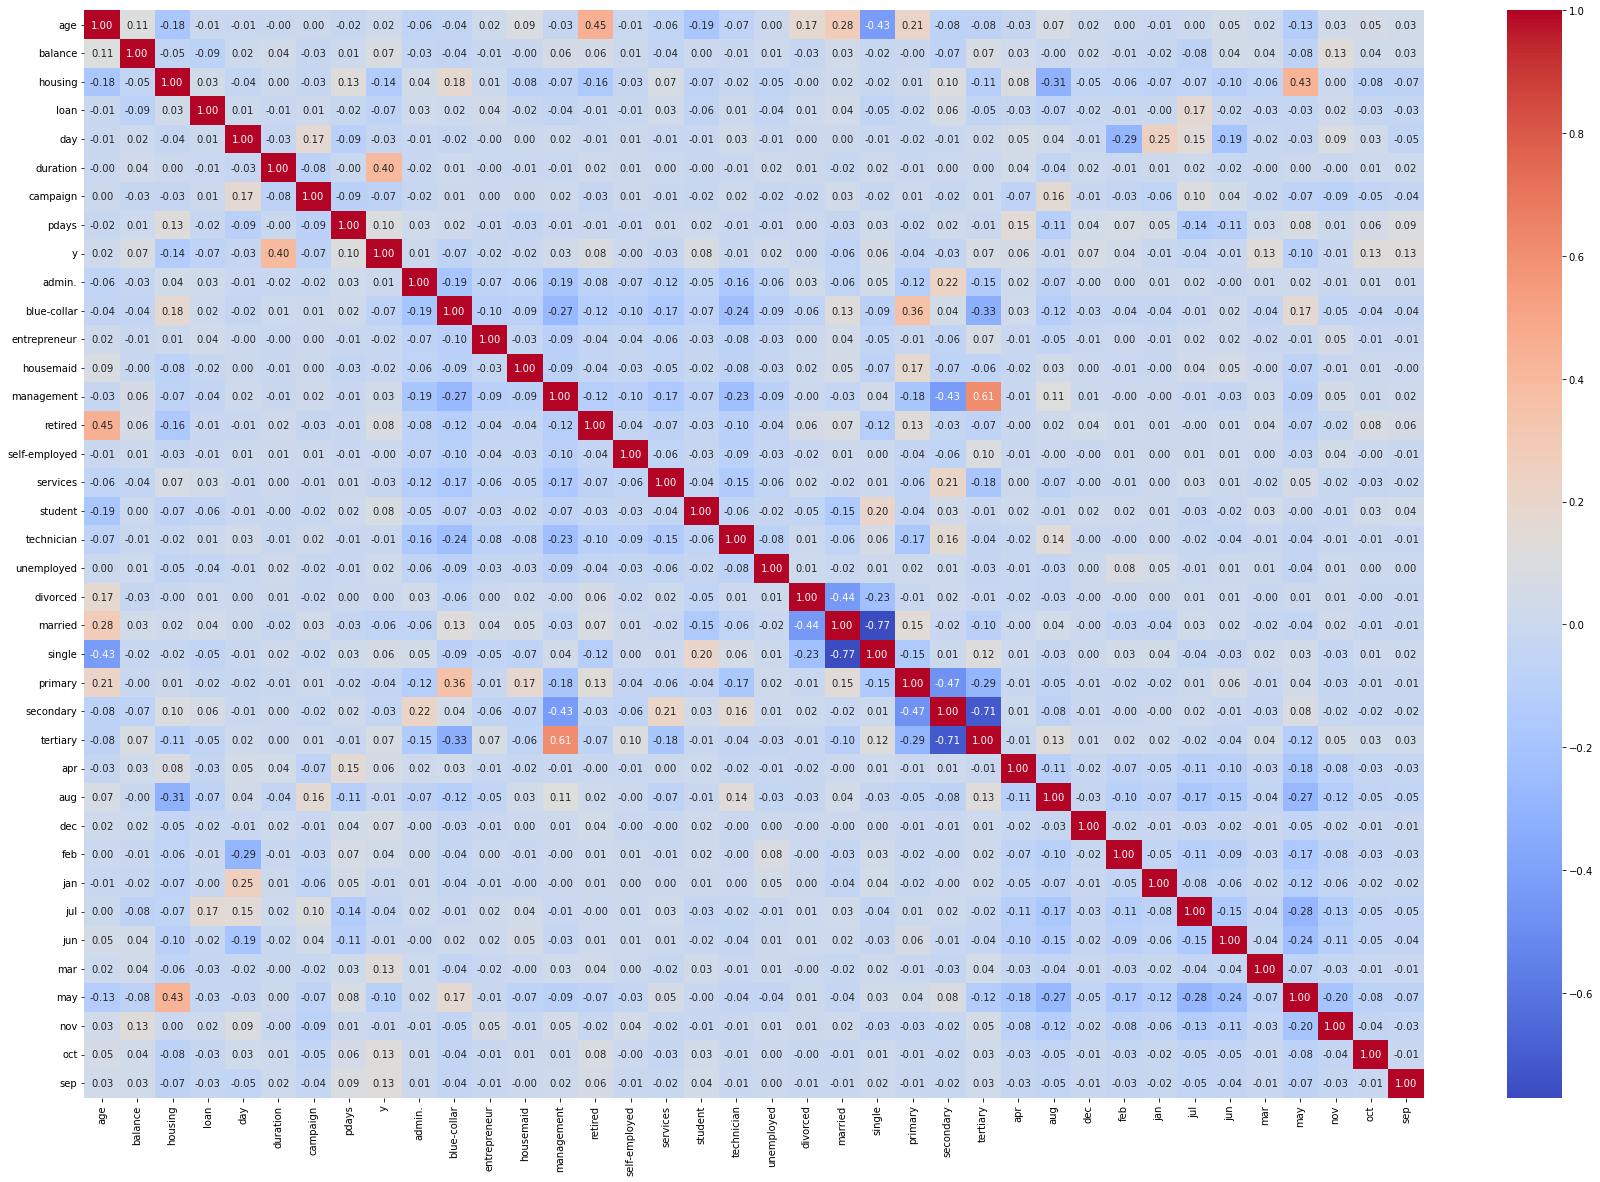

In [44]:
plot_correlation(dataset.corr())

Possiamo osservare che:
- l'eta' di un individuo e' correlata con il suo stato coniugale, come ci si puo' aspettare
- l'eta' di un individuo e' correlata con lo stato lavorativo dell'individuo, soprattutto con lo stato di pensionato
- I prestiti per le case sono fatti prevalentemente in certi mesi dell'anno e meno in altri
- La durata dell'interlocuzione con l'utente influenza molto l'inscrizione al deposito
- Il tipo di lavoro dipende dal livello di istruzione
- Come aspettato i vari stati coniugali hanno un indice basse tra di loro
- Lo stesso vale per lo stato di apprendimento

## Modellazione

In [45]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = dataset.drop(columns=["y"])
y = dataset["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

Come abbiamo visto nella parte di esplorazione dei dati la nostra variabile target che vogliamo predirre `y` ha una distribuzione molto sbilanciata e per questo effetuiamo un oversampling sui nostri valori per avere risultati migliori.

In [46]:
smote = SMOTE(random_state=42)
X_train, y_train =smote.fit_resample(X_train, y_train)

In [47]:
def plot_confusion(matrix, figsize=(5, 5), title="Confusion Matrix"):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, cmap="coolwarm", annot=True, fmt="d", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

models = {}
skf = StratifiedKFold(5, shuffle=True, random_state=42)

def print_grid_search_results(grid_search):
    print("Best score: %f" % grid_search.best_score_)
    print("Best parameters set:")
    best_params = grid_search.best_params_
    for param_name in sorted(best_params.keys()):
        print("\t%s: %r" % (param_name, best_params[param_name]))
    print(grid_search.best_estimator_)

def grid_search_cv(model, grid, X_train, y_train, cv=skf):
    grid_search = GridSearchCV(model, grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print_grid_search_results(grid_search)
    return grid_search.best_estimator_, grid_search

In [49]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

def set_model_precision_recall_f1(model, y_test, y_pred):
    model["precision"] = precision_score(y_test, y_pred, pos_label=1)
    model["recall"] = recall_score(y_test, y_pred, pos_label=1)
    model["f1"] = f1_score(y_test, y_pred, average="macro")
    print(classification_report(y_test, y_pred))

### Perceptron

Il Perceptron e' un algoritmo di classificazione semplice adatto per learning di larga scala.

Eseguiamo una Grid Search sui parametri:
- `scaler`: *StandardScaler* - Standardizzare le caratteristiche rimuovendo la media e ridimensionandole alla varianza unitaria.
- `penality`: La metodologia di penalizzazione utilizzata
- `alpha`: Costante che moltiplica il termine di regolarizzazione, se la regolarizzazione e' usata.
- `class_weight`: *balanced* - Usa i valori di y per aggiustare automaticamente i pesi, in modo inversamente proporzionale alla frequenza della classe nei dati di input;
In modo `n_samples / (n_classes * np.bincount(y))`.

In [51]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron", Perceptron(n_jobs=-1, random_state=42))
])

perceptron_grid = {
    "scaler": [None, StandardScaler()],
    "perceptron__penalty": [None, "l1", "l2", "elasticnet"],
    "perceptron__alpha": np.logspace(-5, 5, 11),
    "perceptron__class_weight": [None, "balanced"],
}

perceptron_model, perceptron_grid_search = grid_search_cv(perceptron_model, perceptron_grid, X_train, y_train)
models["perceptron"] = { 
    "best_model": perceptron_model, 
    "grid_search": perceptron_grid_search 
}

Best score: 0.920925
Best parameters set:
	perceptron__alpha: 1e-05
	perceptron__class_weight: 'balanced'
	perceptron__penalty: None
	scaler: StandardScaler()
Pipeline(steps=[('scaler', StandardScaler()),
                ('perceptron',
                 Perceptron(alpha=1e-05, class_weight='balanced', n_jobs=-1,
                            random_state=42))])


In [52]:
models["perceptron"]["y_predict"] = models["perceptron"]["best_model"].predict(X_test)
set_model_precision_recall_f1(models["perceptron"], y_test, models["perceptron"]["y_predict"])

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     12098
           1       0.46      0.26      0.33      1581

    accuracy                           0.88     13679
   macro avg       0.68      0.61      0.63     13679
weighted avg       0.86      0.88      0.86     13679



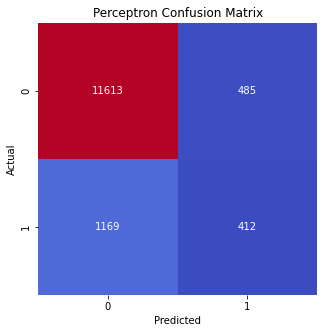

In [53]:
from sklearn.metrics import confusion_matrix

plot_confusion(confusion_matrix(y_test, models["perceptron"]["y_predict"]), title="Perceptron Confusion Matrix")

<Axes: >

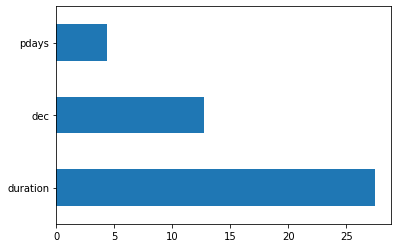

In [54]:
perceptron_influence = pd.Series(models["perceptron"]["best_model"][1].coef_[0], index=X_train.columns)
perceptron_influence.nlargest(3).plot(kind='barh')

Come si nota dalla nostra matrice di confusione e anche ai 

### Logistic Regression

La LogisticRegression nonostante il suo nome e' implementata come un modello lineare per la classificazione piuttosto che per la regressione come si potrebbe intendere dalla nomenclatura. In questo modello le probabilita' che descrivono i possibili risultati di una singola prova sono modellati utilizzando una funzione logistica.

Eseguiamo una Grid Search sui parametri:
- `scaler`: *StandardScaler* - Standardizzare le caratteristiche rimuovendo la media e ridimensionandole alla varianza unitaria.
- `penality`: La metodologia di penalizzazione utilizzata
- `C`: L'inverso della forza di regolarizzazione (valori piu' piccoli specificano una regolarizzazione piu' forte).
- `solver`: L'algoritmo da usare nel problema di ottimizzazione. *liblinear* - Buona scelta per dtataset piccoli. *saga* - Veloci per dataset piu' grandi.
- `class_weight`: *balanced* - Usa i valori di y per aggiustare automaticamente i pesi, in modo inversamente proporzionale alla frequenza della classe nei dati di input;
In modo `n_samples / (n_classes * np.bincount(y))`.

In [67]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logistic_regression_model = Pipeline([
    ("scaler", StandardScaler()),
    ("logistic_regression", LogisticRegression(n_jobs=-1, random_state=42))
])

logistic_regression_grid = {
    "scaler": [None, StandardScaler()],
    "logistic_regression__penalty": ["l2", "l1"],
    "logistic_regression__C": np.logspace(-4, 2, 7),
    'logistic_regression__solver': ['liblinear', 'saga'],
    "logistic_regression__class_weight": [None, "balanced"],
}

logistic_regression_model, logistic_regression_grid_search = grid_search_cv(logistic_regression_model, logistic_regression_grid, X_train, y_train)
models["logistic_regression"] = { 
    "best_model": logistic_regression_model, 
    "grid_search": logistic_regression_grid_search 
}

c:\Users\User\anaconda3\envs\va\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(


Best score: 0.938898
Best parameters set:
	logistic_regression__C: 1.0
	logistic_regression__class_weight: None
	logistic_regression__penalty: 'l1'
	logistic_regression__solver: 'liblinear'
	scaler: None
Pipeline(steps=[('scaler', None),
                ('logistic_regression',
                 LogisticRegression(n_jobs=-1, penalty='l1', random_state=42,
                                    solver='liblinear'))])


In [68]:
models["logistic_regression"]["y_predict"] = models["logistic_regression"]["best_model"].predict(X_test)
set_model_precision_recall_f1(models["logistic_regression"], y_test, models["logistic_regression"]["y_predict"])

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12098
           1       0.59      0.30      0.40      1581

    accuracy                           0.89     13679
   macro avg       0.75      0.64      0.67     13679
weighted avg       0.88      0.89      0.88     13679



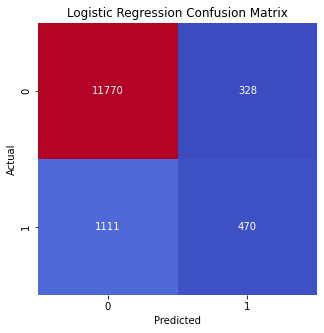

In [69]:
from sklearn.metrics import confusion_matrix

plot_confusion(confusion_matrix(y_test, models["logistic_regression"]["y_predict"]), title="Logistic Regression Confusion Matrix")

<Axes: >

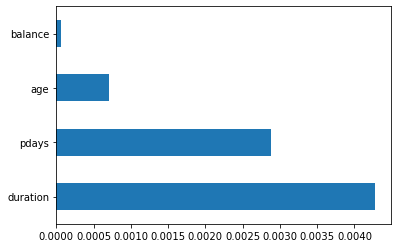

In [70]:
logistic_influence = pd.Series(models["logistic_regression"]["best_model"][1].coef_[0], index=X_train.columns)
logistic_influence.nlargest(4).plot(kind='barh')

### SVM

L'SVM, o Support Vector Machines, e' un classificatore lineare binario non probabilistico. Un modello SVM è una rappresentazione degli esempi come punti nello spazio, mappati in modo tale che gli esempi appartenenti alle due diverse categorie siano chiaramente separati da uno spazio il più possibile ampio. I nuovi esempi sono quindi mappati nello stesso spazio e la predizione della categoria alla quale appartengono viene fatta sulla base del lato nel quale ricade.

Eseguiamo una Grid Search sui parametri:
- `kernel`: Specifica il tipo di kernel da utilizzare nell'algoritmo.
- `C`: Parametro di regolarizzazione. La forza della regolarizzazione e' inversamente proporzionale a C. La penalita' e' di tipo l2 al quadrato.
- `class_weight`: *balanced* - Usa i valori di y per aggiustare automaticamente i pesi, in modo inversamente proporzionale alla frequenza della classe nei dati di input;
In modo `n_samples / (n_classes * np.bincount(y))`.

In [62]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=42))
])

svm_grid = [{
    'svm__kernel': ['rbf', 'poly'],
    'svm__C': [0.1, 1, 5],
    "svm__class_weight": [None, "balanced"],
}]

svm_model, svm_grid_search = grid_search_cv(svm_model, svm_grid, X_train, y_train)
models["svm"] = { 
    "best_model": svm_model, 
    "grid_search": svm_grid_search 
}

Best score: 0.939747
Best parameters set:
	svm__C: 5
	svm__class_weight: 'balanced'
	svm__kernel: 'rbf'
Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=5, class_weight='balanced', random_state=42))])


In [63]:
models["svm"]["y_predict"] = models["svm"]["best_model"].predict(X_test)
set_model_precision_recall_f1(models["svm"], y_test, models["svm"]["y_predict"])

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     12098
           1       0.57      0.33      0.42      1581

    accuracy                           0.89     13679
   macro avg       0.74      0.65      0.68     13679
weighted avg       0.88      0.89      0.88     13679



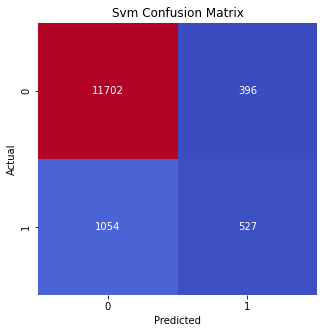

In [64]:
from sklearn.metrics import confusion_matrix

plot_confusion(confusion_matrix(y_test, models["svm"]["y_predict"]), title="Svm Confusion Matrix")

<Axes: >

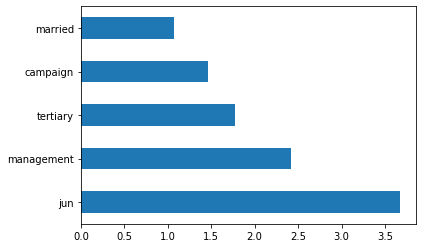

In [65]:
svm_influence = pd.Series(models["svm"]["best_model"][1].support_vectors_[0], index=X_train.columns)
svm_influence.nlargest(5).plot(kind='barh')

### Random Forest

In RandomForest ogni albero dell'insieme e' costruito da un campione pescato con sostituzione dal training set. Inoltre, quando ogni nodo viene separato durante la costruzione di un albero, la migliore separazione viene trovata tramite tutte le caratteristiche, o un sottoinsieme randomico di dimensione decidibile. L'obbiettivo di questo elemento randomico e' quello di diminuire la varianza di un forest estimator. Questa elemento randomico produce alberi decisionali con errori di predizione disaccoppiati, inoltre prendendo una media di queste predizioni alcuni errori possono essere cancellati. Questo modello produce una varianza ridotta combinando diversi alberi, portando ad un modello migliore.

Eseguiamo una Grid Search sui parametri:
- `n_estimators`: Il numero di alberi nella foresta.
- `max_depth`: La profondita' massima dell'albero.
- `min_samples_split`: Il numero minimo di campioni necessari per dividere un nodo interno.
- `min_samples_leaf`: Il numero minimo di campioni necessari per essere ad un nodo di tipo foglia.
- `class_weight`: *balanced* - Usa i valori di y per aggiustare automaticamente i pesi, in modo inversamente proporzionale alla frequenza della classe nei dati di input;
In modo `n_samples / (n_classes * np.bincount(y))`.

In [71]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

random_forest_model = Pipeline([
    ('scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier(n_jobs=-1, random_state=42))
])

random_forest_grid = {
    'random_forest__n_estimators': [100, 200, 300],
    'random_forest__max_depth': [2, 6, 10],
    'random_forest__min_samples_split': [2, 4, 8],
    'random_forest__min_samples_leaf': [1, 2, 4],
    "random_forest__class_weight": [None, "balanced"],
}

random_forest_model, random_forest_grid = grid_search_cv(random_forest_model, random_forest_grid, X_train, y_train)
models["random_forest"] = { 
    "best_model": random_forest_model, 
    "grid_search": random_forest_grid 
}

Best score: 0.932086
Best parameters set:
	random_forest__class_weight: None
	random_forest__max_depth: 10
	random_forest__min_samples_leaf: 1
	random_forest__min_samples_split: 4
	random_forest__n_estimators: 300
Pipeline(steps=[('scaler', StandardScaler()),
                ('random_forest',
                 RandomForestClassifier(max_depth=10, min_samples_split=4,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])


In [72]:
models["random_forest"]["y_predict"] = models["random_forest"]["best_model"].predict(X_test)
set_model_precision_recall_f1(models["random_forest"], y_test, models["random_forest"]["y_predict"])

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     12098
           1       0.50      0.55      0.52      1581

    accuracy                           0.88     13679
   macro avg       0.72      0.74      0.73     13679
weighted avg       0.89      0.88      0.89     13679



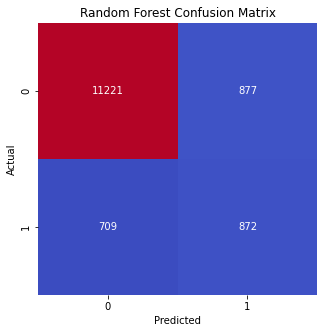

In [73]:
from sklearn.metrics import confusion_matrix

plot_confusion(confusion_matrix(y_test, models["random_forest"]["y_predict"]), title="Random Forest Confusion Matrix")

<Axes: >

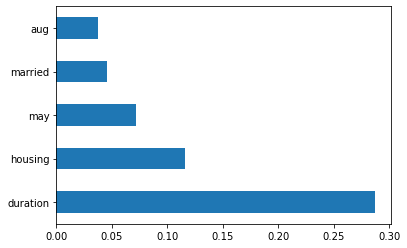

In [74]:
pc_imp = pd.Series(models["random_forest"]["best_model"][1].feature_importances_, index=X_train.columns)
pc_imp.nlargest(5).plot(kind='barh')

Come possiamo osservare in tutti i modelli utilizzati la `duration` si conferma essere l'elemento di gran lunga piu' influente sul nostro modello.

## Comparazione dei modelli

In [101]:
def compare_models(error1, error2):
    z = 1.96
    d = np.abs(error1 - error2)
    variance_pow_2 = error1 * (1 - error1) / len(y_test) + error2 * (1 - error2) / len(y_test)
    d_min = d - z * np.sqrt(variance_pow_2)
    d_max = d + z * np.sqrt(variance_pow_2)
    print("Intervallo di confidenza: [{:f}, {:f}]".format(d_min, d_max))

In [102]:
for model in models:
    models[model]["error"] = 1 - models[model]["f1"]

#### Perceptron vs Logistic Regression

In [103]:
print("Perceptron vs Logistic Regression")
compare_models(models["perceptron"]["error"], models["logistic_regression"]["error"])

Perceptron vs Logistic Regression
Intervallo di confidenza: [0.024445, 0.047024]


#### Perceptron vs SVM

In [104]:
print("Perceptron vs SVM")
compare_models(models["perceptron"]["error"], models["svm"]["error"])

Perceptron vs SVM
Intervallo di confidenza: [0.037035, 0.059504]


#### Perceptron vs Random Forest

In [105]:
print("Perceptron vs Random Forest")
compare_models(models["perceptron"]["error"], models["random_forest"]["error"])

Perceptron vs Random Forest
Intervallo di confidenza: [0.084847, 0.106823]


#### Logistic Regression vs SVM

In [106]:
print("Logistic Regression vs SVM")
compare_models(models["logistic_regression"]["error"], models["svm"]["error"])

Logistic Regression vs SVM
Intervallo di confidenza: [0.001436, 0.023634]


#### Logistic Regression vs Random Forest

In [107]:
print("Logistic Regression vs Random Forest")
compare_models(models["logistic_regression"]["error"], models["random_forest"]["error"])

Logistic Regression vs Random Forest
Intervallo di confidenza: [0.049251, 0.070950]


#### SVM vs Random Forest

In [108]:
print("SVM vs Random Forest")
compare_models(models["svm"]["error"], models["random_forest"]["error"])

SVM vs Random Forest
Intervallo di confidenza: [0.036773, 0.058358]
